In [1]:
import os
import shutil
import copy
import time
import numpy as np
from sklearn.utils import shuffle
from collections import namedtuple
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay

import torch
import torchvision
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import _LRScheduler 

import cv2
import PIL
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
def show_dataset(dataset, n=6):
    
    img = np.vstack((np.hstack((np.asarray(dataset[25+i][0]) for _ in range(n)))
                   for i in range(5)))
    plt.imshow(img)
    plt.axis('off')

In [3]:
TRAIN_RATIO = 0.8

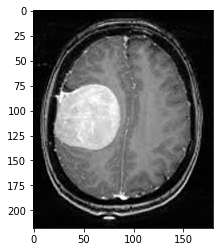

In [4]:
path = '/Users/sharduljanaskar/Documents/Brain_tumor_detection'
img = Image.open(path+'/images/yes/Y1.jpg')
plt.imshow(img)

In [5]:
image_dir = os.path.join(path,'images')
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

In [6]:
classes = [c for c in os.listdir(path+'/images/') if not c.startswith('.')]

In [7]:
for c in classes:
    class_dir = os.path.join(image_dir, c)
    
    images = os.listdir(class_dir)
       
    n_train = int(len(images) * TRAIN_RATIO)
    
    train_img = images[:n_train]
    test_img = images[n_train:]
    
    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
    for image in train_img:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image) 
        shutil.copyfile(image_src, image_dst)
        
    for image in test_img:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image) 
        shutil.copyfile(image_src, image_dst)

In [11]:
train_data = datasets.ImageFolder(root=train_dir,transform=transforms.ToTensor())

In [12]:
mean = torch.zeros(3)
std = torch.zeros(3)

for img, label in train_data:
    mean += torch.mean(img,dim=(1,2))
    std += torch.std(img,dim=(1,2))

mean /= len(train_data)
std /= len(train_data)

print(f'Calculated means: {mean}')
print(f'Calculated stds: {std}')

Calculated means: tensor([0.2501, 0.2504, 0.2505])
Calculated stds: tensor([0.2202, 0.2204, 0.2206])


In [13]:
pretrained_size = (224,224)
pretrained_means = [0.2501, 0.2504, 0.2505]
pretrained_stds= [0.2202, 0.2204, 0.2206]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.ColorJitter(hue=.05, saturation=.05),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ColorJitter(hue=.05, saturation=.05),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [14]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [15]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [16]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [17]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 181
Number of validation examples: 21
Number of testing examples: 51


In [18]:

def data_summary(main_path):
    
    yes_path = main_path+'/yes'
    no_path = main_path+'/no'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(os.listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(os.listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")

In [19]:
data_summary(train_dir)

Number of examples: 202
Percentage of positive examples: 61.386138613861384%, number of pos examples: 124
Percentage of negative examples: 38.613861386138616%, number of neg examples: 78


In [20]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [21]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min,max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [22]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

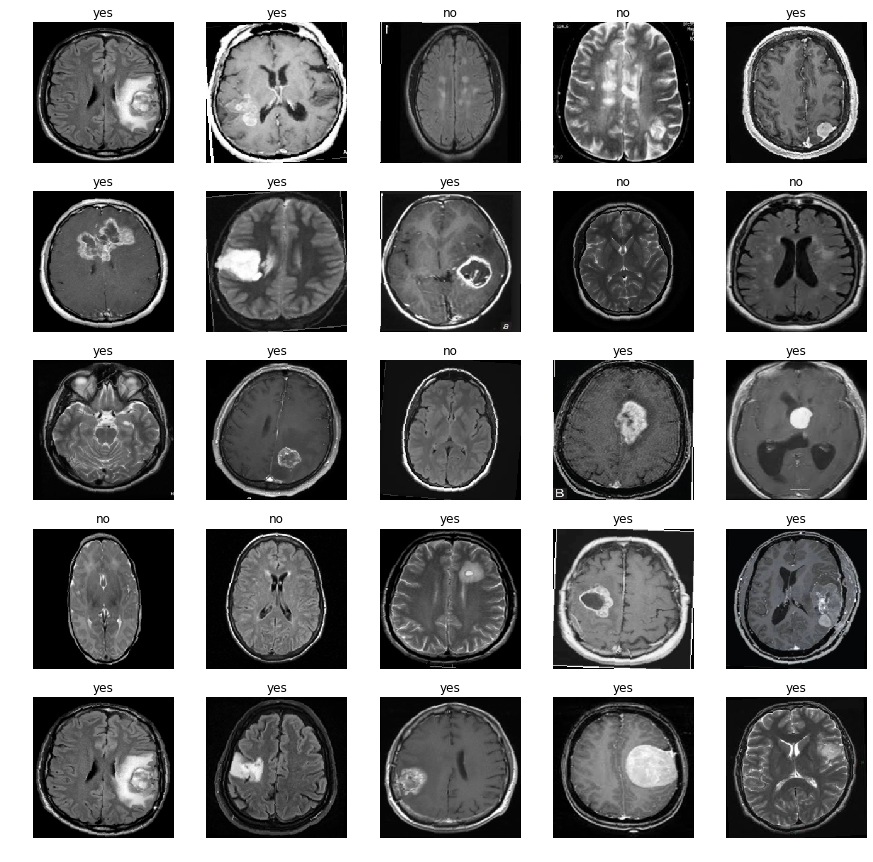

In [23]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [24]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
        
        block, n_blocks, channels = config
        self.in_channels = channels[0]
        
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2,padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride=2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride=2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride=1):
        
        layers = []
        
        if self.in_channels != block.expansion*channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1,n_blocks):
            layers.append(block(block.expansion*channels, channels))
        
        self.in_channels = block.expansion*channels
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [25]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv,bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
        
        x += i
        x = self.relu(x)
        
        return x
        

In [26]:
ResNetConfig = namedtuple('ResNetConfig',['block', 'n_blocks', 'channels'])

resnet18 = ResNetConfig(block=BasicBlock, n_blocks=[2,2,2,2], channels=[64,128,256,512])

In [27]:
pretrained_model = models.resnet18(pretrained=True)

In [28]:
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_FEATURES = len(test_data.classes)

In [31]:
fc = nn.Linear(IN_FEATURES, OUTPUT_FEATURES)

In [32]:
pretrained_model.fc = fc

In [33]:
model = ResNet(resnet18,OUTPUT_FEATURES)

In [34]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,177,538 trainable parameters


In [36]:
START_LR = 1e-7

optimizer = torch.optim.Adam(model.parameters(),lr=START_LR)

device = torch.device('cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [34]:
device = torch.device('cpu')
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [37]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [206]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [208]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

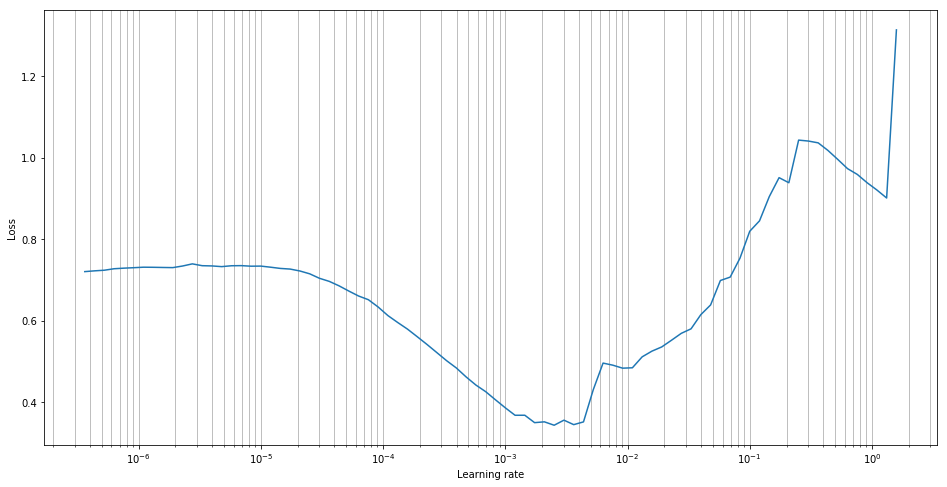

In [210]:
plot_lr_finder(lrs, losses)

In [38]:
FOUND_LR = 1e-3

params = [
          {"params" : model.conv1.parameters(), "lr" : FOUND_LR/10},
          {"params" : model.bn1.parameters(), "lr" : FOUND_LR/10},
          {"params" : model.layer1.parameters(), "lr" : FOUND_LR/8},
          {"params" : model.layer2.parameters(), "lr" : FOUND_LR/6},
          {"params" : model.layer3.parameters(), "lr" : FOUND_LR/4},
          {"params" : model.layer4.parameters(), "lr" : FOUND_LR/2},
          {"params" : model.fc.parameters()}
        ]

optimizer = torch.optim.Adam(params, lr = FOUND_LR)

In [39]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS*STEPS_PER_EPOCH

MAX_LR = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, total_steps=TOTAL_STEPS)

In [40]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [41]:
def train_model(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_acc = 0
    epoch_loss = 0
    
    model.train()
    
    for x,y in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        y_pred, _ = model(x)
        
        loss = criterion(y_pred,y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)       

In [42]:
def evaluate_model(model, iterator, criterion, device):
    
    epoch_acc = 0
    epoch_loss = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for x,y in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred,y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)       

In [43]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [44]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc = evaluate_model(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 51s
	Train Loss: 0.650 | Train Acc: 66.10%
	 Val. Loss: 0.408 |  Val. Acc: 95.24%
Epoch: 02 | Epoch Time: 0m 51s
	Train Loss: 0.280 | Train Acc: 90.58%
	 Val. Loss: 0.159 |  Val. Acc: 95.24%
Epoch: 03 | Epoch Time: 0m 52s
	Train Loss: 0.118 | Train Acc: 95.56%
	 Val. Loss: 0.610 |  Val. Acc: 90.48%
Epoch: 04 | Epoch Time: 0m 55s
	Train Loss: 0.060 | Train Acc: 97.92%
	 Val. Loss: 0.451 |  Val. Acc: 80.95%
Epoch: 05 | Epoch Time: 0m 53s
	Train Loss: 0.068 | Train Acc: 96.60%
	 Val. Loss: 0.203 |  Val. Acc: 85.71%
Epoch: 06 | Epoch Time: 0m 50s
	Train Loss: 0.049 | Train Acc: 97.92%
	 Val. Loss: 0.358 |  Val. Acc: 85.71%
Epoch: 07 | Epoch Time: 0m 51s
	Train Loss: 0.018 | Train Acc: 99.21%
	 Val. Loss: 0.184 |  Val. Acc: 90.48%
Epoch: 08 | Epoch Time: 0m 53s
	Train Loss: 0.027 | Train Acc: 99.21%
	 Val. Loss: 0.097 |  Val. Acc: 95.24%
Epoch: 09 | Epoch Time: 0m 51s
	Train Loss: 0.011 | Train Acc: 99.48%
	 Val. Loss: 0.080 |  Val. Acc: 95.24%
Epoch: 10 | Epoch T

In [45]:
model.load_state_dict(torch.load('model.pt'))

test_loss, test_acc = evaluate_model(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.351 | Test Acc: 90.62%


In [46]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [47]:
images, labels, probs = get_predictions(model, test_iterator)

In [48]:
pred_labels = torch.argmax(probs, 1)

In [49]:
corrects = torch.eq(labels, pred_labels)

In [50]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [51]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

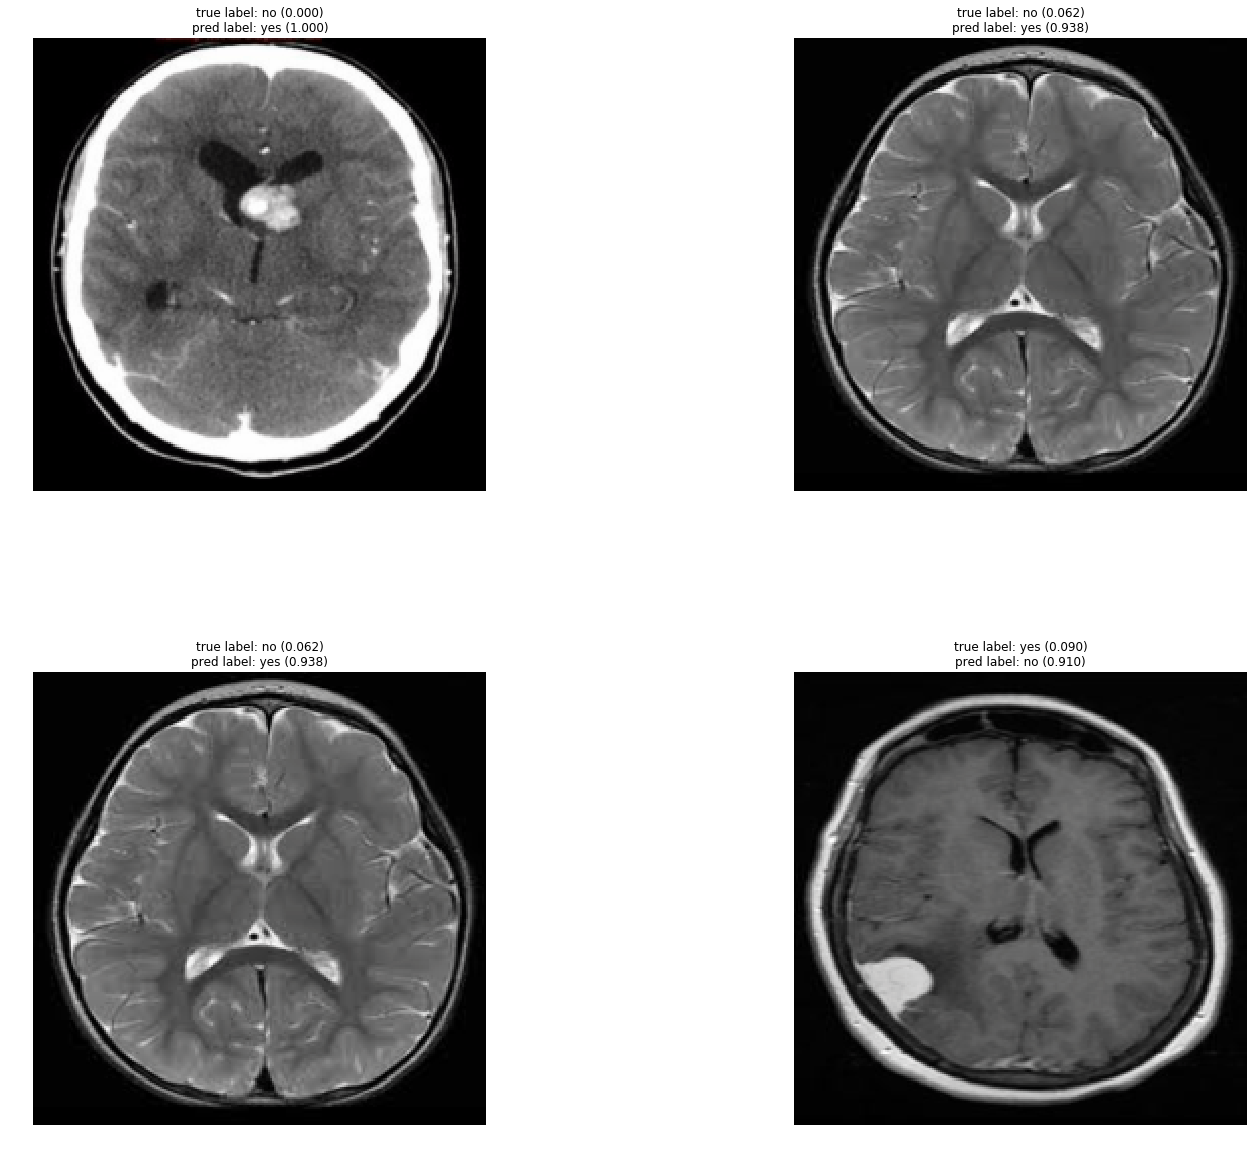

In [52]:
N_IMAGES = 5

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [55]:
def plot_filtered_image(images, filters, n_filters=None, normalize=False):
    
    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()
    
    if n_filters is not None:
        filters = filters[:n_filters]
        
    n_images = images.shape[0]
    n_filters = filters.shape[0]
    
    filtered_images = F.conv2d(images, filters)
    
    fig = plt.figure(figsize=(30,30))
    
    for i in range(n_images):
        
        image = images[i]
    
        if normalize:
            image = normalize_image(image)
        
        ax = fig.add_subplot(n_images, n_filters+1, i+1+(n_filters*i))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')
        
        for j in range(n_filters):
            
            image = filtered_images[i][j]
            
            if normalize:
                image = normalize_image(image)
            
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(n_filters*i)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');
        
    fig.subplots_adjust(hspace = -0.8)     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


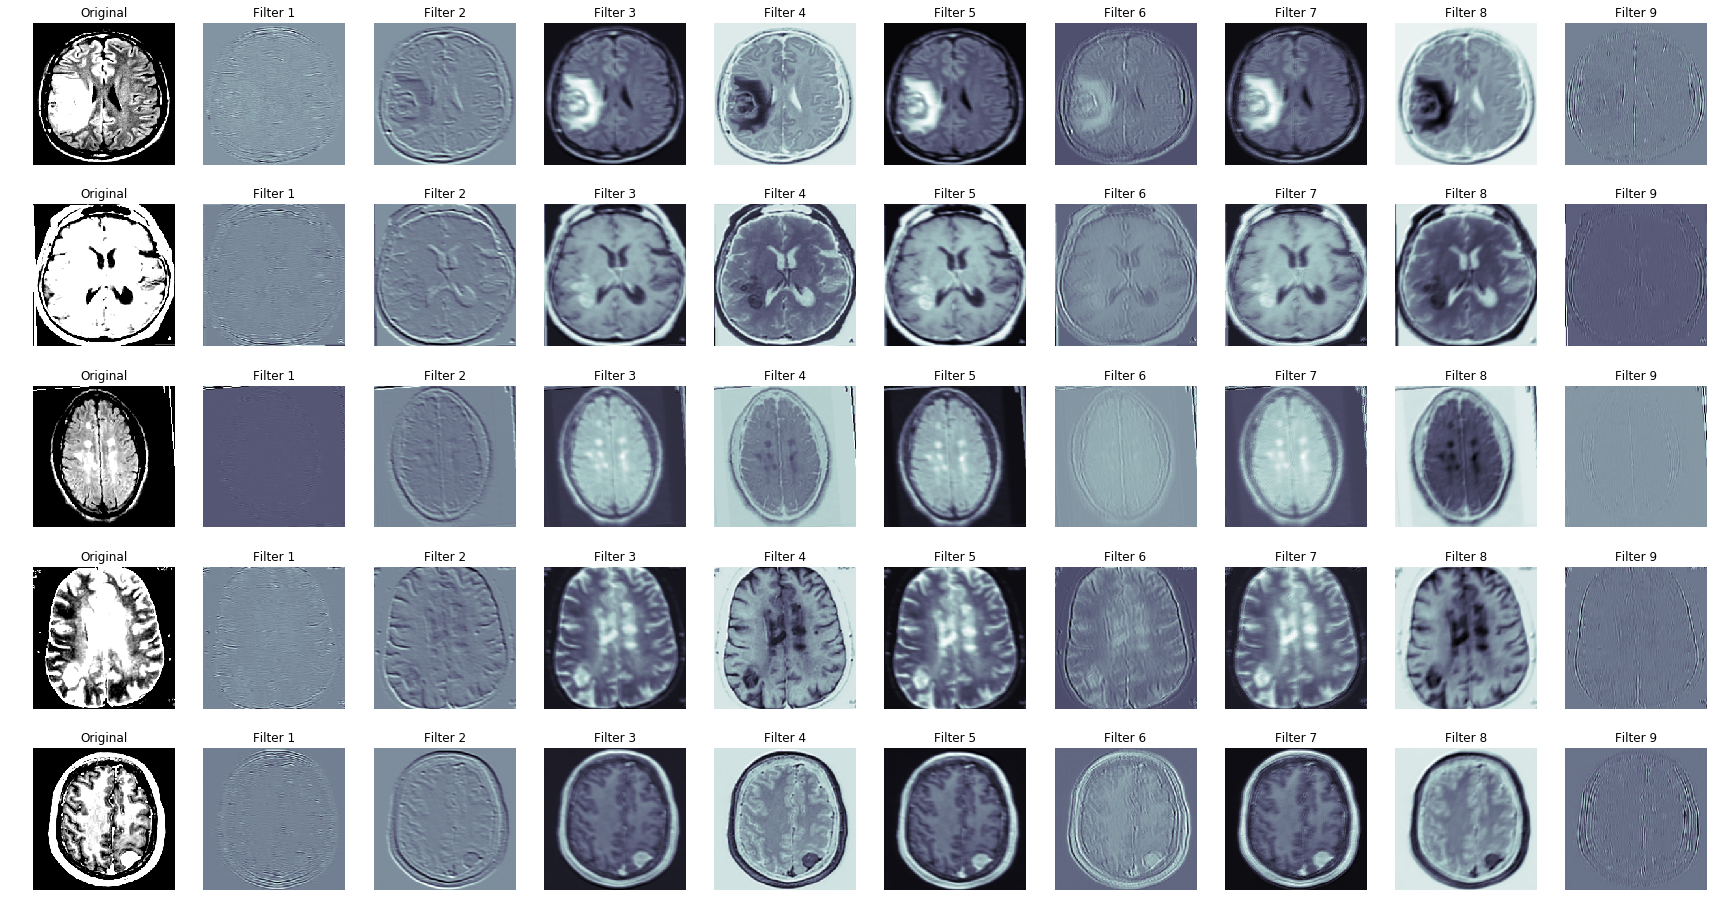

In [56]:
N_IMG = 5
N_FILTERS = 9

images = [image for image,label in [train_data[i]for i in range(N_IMG)]]
filters = model.conv1.weight.data

plot_filtered_image(images, filters, N_FILTERS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


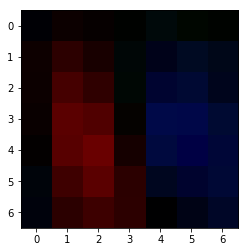

In [57]:
plt.imshow(filters[5].permute(1,2,0))

In [58]:
f = model.layer1[0].conv1.weight.data

In [59]:
fi = f[0].permute(1,2,0)

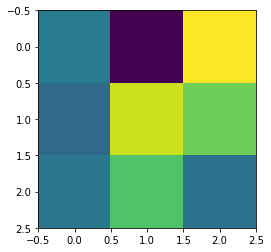

In [60]:
plt.imshow(fi[:,:,20])

In [61]:
filters[0].shape

torch.Size([3, 7, 7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


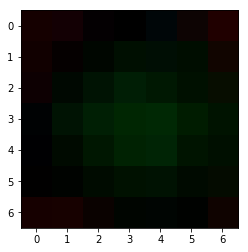

In [62]:
plt.imshow(filters[45].permute(1,2,0))